# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


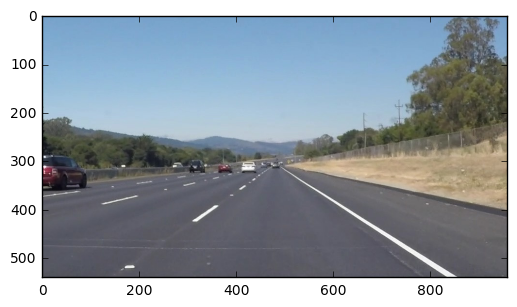

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


#fig = plt.figure()

#ax1 = fig.add_subplot(211)
#ax1.imshow(image)



**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image    

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [40]:
def detect_lanes_from_path(path):
    image = mpimg.imread(path)
    return detect_lanes(image)
    
def detect_lanes(image):
    # convert to grayscale
    #gray = grayscale(image)
    #if debug: cv2.imwrite('debug/'+index+'.1gray.jpg', gray)
    
    # blur using a gaussian blur
    blur = gaussian_blur(image, 3)
    #if debug: cv2.imwrite('debug/'+index+'.2blur.jpg', blur)
    
    # detect edges
    canny_img = canny(blur, 70, 200)
    #if debug: cv2.imwrite('debug/'+index+'.3cannny.jpg', canny_img)
    
    # calculate region of interest
    imshape = image.shape
    x0, y0 = 0, imshape[0]
    x1, y1 = int(imshape[1]/2)-50, int(imshape[0]/2)+50
    x2, y2 = int(imshape[1]/2)+50, int(imshape[0]/2)+50
    x3, y3 = imshape[1], imshape[0]
    
    # mask region of interest
    polygon = np.array([[(x0,y0),(x1,y1), (x2,y2), (x3,y3)]], dtype=np.int32)
    interest_img = region_of_interest(canny_img, polygon)
    #if debug: cv2.imwrite('debug/'+index+'.4interest_img.jpg', interest_img)
    
    # hogh lines
    lines_img, lines = hough_lines(interest_img, 2, np.pi/180, 20, 2, 2)
    #if debug:
    #   cv2.imwrite('debug/'+index+'.5lines.jpg', lines_img)
        
    # draw lanes
    lanes_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lanes = calculate_lanes(lines, image.shape)
    global all_lanes
    all_lanes.append(lanes)
    lanes = average_lanes(all_lanes)
    draw_lines(image, lanes, [255,0,255],10)
    #if debug:
    #    cv2.imwrite('debug/'+index+'.6lanes.jpg',lanes_img)
    
    # add to original image
    #img = weighted_img(lanes_img, image)
    #if debug:
    #    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #    cv2.imwrite('debug/'+index+'.7final.jpg', img2)
    return image
    
def calculate_lanes(lines, shape):
    lines = np.squeeze(lines)
    
    # calculate slopes
    slopes = (lines[:,3] - lines[:,1]) / (lines[:,2] - lines[:,0])
    
    # reject lines that are too horizontal
    min_slope = 0.2
    lines = lines[abs(slopes) > min_slope]
    slopes = slopes[abs(slopes) > min_slope]
    
    # reject lines that are too vertical
    max_slope = 1000
    lines = lines[abs(slopes) < max_slope]
    slopes = slopes[abs(slopes) < max_slope]
    
    # group slopes and lines into left and right
    left_slopes, right_slopes = slopes[slopes < 0], slopes[slopes > 0]
    left_lines, right_lines = lines[slopes < 0], lines[slopes > 0]
        
    # calculate intercepts
    left_bs = left_lines[:,1] - left_slopes * left_lines[:,0]
    right_bs = right_lines[:,1] - right_slopes * right_lines[:,0]
    
    # calculage average slopes & intercepts
    left_slope, right_slope = left_slopes.mean(), right_slopes.mean()
    left_b, right_b = left_bs.mean(), right_bs.mean()
    
    bottom = shape[0]
    top = shape[0] / 1.5
    
    x1_left = (bottom - left_b) / left_slope
    x2_left = (top - left_b) / left_slope
    
    x1_right = (bottom - right_b) / right_slope
    x2_right = (top - right_b) / right_slope    
    
    return [[[x1_left, bottom, x2_left, top]], [[x1_right, bottom, x2_right, top]]]

def average_lanes(lanes, window = 5):
    left = np.array([0, 0, 0, 0])
    right = np.array([0, 0, 0, 0])
    
    for i, entry in enumerate(reversed(lanes)):
        if window == i:
            break
        
        left = left + entry[0][0]
        right = right + entry[1][0]
        
    points = window if window < len(lanes) else len(lanes)
        
    left = left / points
    right = right / points
    
    return [[left], [right]]
    
def draw_region_of_interest(img, points, color=[0,255,0], thickness=2):
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[i + 1 % len(points)]
        cv2.line(img, p1, p2, color, thickness)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

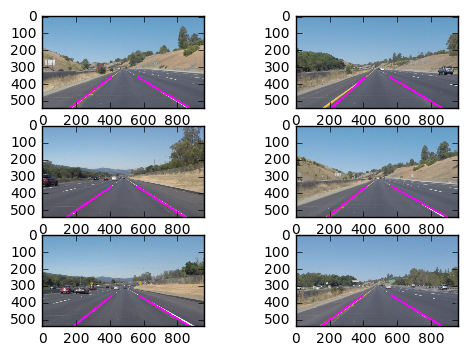

In [42]:
import os
images = os.listdir("test_images")

debug = True
all_lanes = []
#result = detect_lanes_from_path("test_images/"+images[0])
#plt.imshow(result)
for i,path in enumerate(images):
    all_lanes = []
    result = detect_lanes_from_path("test_images/"+path)
    plt.subplot(3,2,i+1)
    plt.imshow(result)
    mpimg.imsave('test_images_out/'+path, result)
    
    

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    global img_index
    img_index += 1
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    img = detect_lanes(image)

    return img

Let's try the one with the solid white lane on the right first ...

In [43]:
img_index = 0
all_lanes = []
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 45.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.38 s, sys: 139 ms, total: 3.52 s
Wall time: 5.57 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}?t=9">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [45]:
img_index = 0
all_lanes = []
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 43.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11 s, sys: 468 ms, total: 11.4 s
Wall time: 16.5 s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}?t=11">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Hello,

### Pipeline

My pipeline works by first taking the image an performing canny edge detection, then using the hough transform algorithm to find straight lines. I calculated the slopes and grouped the negative and positive slopes together. The positive slopes are the left lane lines. The negative slopes are the right lane lines. I calculated the intercepts of those lines, then averaged the left slopes, right slopes, left intercepts and right intercepts. Then holding y constant I calculated the x points for the left and right lane lines.

In the videos, the lines were pretty jittery. I saw some suggestions of smoothing out the lane lines over time. I simply average the last five lanes lines by averaging the x and y points.

I spent a lot of time playing with the parameters for canny edge detection and hough transforms seeing if the last video would work. It wasn't until someone pointed out that you can just do canny edge detection on a color image. I thought it had to be done on a gray scale image. The yellow line was not detected in grayscale.

I also ignored lines with slopes that were too horizontal or too vertical.

### Possible Failures

In my opinion the region of interest is one of the most important parts. Initially the region of interest was hardcoded and that didn't work with the other video because the image is bigger. If the camera is not position correctly or the camera is moved, then the region of interest would change, so that is a failure point.

I could probably really optimize the parameters so that they work well with these videos, but those parameters might not be ideal for different lighting or road conditions.

A nice to have would have been to have a curve that would detect when the road is curving. I read somewhere that hough transforms can be used to detect curved lines, but I'm not sure how to go about doing that, and not sure what the output would be. Right now 4 points corresponds to a line, but a curve would be described how?

One possibility would be to make the min_line_length smaller, but then we would pick up more lines that are not part of the lane lines.

Right now detecting the lane lines is fine because there are no other cars in the road, but what about when a car is right in front of us and they are changing lanes? Canny will detect edges from that car and those will probably scew the averaging of the lines.

Another problem might be when our car is changing lanes. For some period of time, the region of interest might not be ideal.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [49]:
img_index = 0
all_lanes = []
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.09 s, sys: 303 ms, total: 8.39 s
Wall time: 13.4 s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}?t=5">
</video>
""".format(challenge_output))